# Results

* Model: voxels-usegan

In [2]:
# # plotly fix
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# print(__version__) # requires version >= 1.9.0
# init_notebook_mode(connected=True)
# iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

In [6]:
!pip install pickle==1.1.2

ERROR: Could not find a version that satisfies the requirement pickle==1.1.2 (from versions: none)
ERROR: No matching distribution found for pickle==1.1.2


In [1]:
import numpy as np
import pandas as pd
from reconstruction.model import LoadModel
#from reconstruction.utils.plot import plot_vol, plot_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# # Load model
# model = LoadModel('arq_dataset', 'data/arq_usegan_extended/', opt='voxels-usegan', evaluate_mode=True)
# # Load data
# # model._load_full_test_set()
# model._load_full_test_set(min_points=1, max_points=4,
#                           min_radius=6, max_radius=12)
# voxels, voxels_target, labels = model.full_test_data

In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
# Load model
model = LoadModel('arq_dataset', 'data/arq_usegan_extended/', opt='voxels-usegan', evaluate_mode=True)
# Load data
model._load_full_test_set()
voxels, voxels_target, labels = model.full_test_data

Found 'data/arq_usegan_extended/generator_log.csv'
Found 'data/arq_usegan_extended/training_log.csv'
Found 'data/arq_usegan_extended/model_generator.h5'
Found 'data/arq_usegan_extended/discriminator_log.csv'
Found 'data/arq_usegan_extended/model_discriminator.h5'
datasets/custom_arq_dataset.npy


In [5]:
results_1 = model.predict(voxels, labels)
results_2 = model.predict(results_1, labels)

def maskedl1(target, incomplete, result):
    incomplete = incomplete.reshape(-1)
    target = target.reshape(-1)[incomplete == -1]
    result = result.reshape(-1)[incomplete == -1]
    l1 = np.abs(target - result)
    return np.mean(l1)

18/18 [==============================] - 396s 22s/step


In [6]:
result_df = pd.DataFrame()
#print(labels)
for lbl in np.unique(labels):
    lbl_txt = model.label_encoder.inverse_transform([lbl])
    #print(lbl_txt)
    t_voxels, t_voxels_target = voxels[labels == lbl], voxels_target[labels == lbl]
    t_results_1, t_results_2 = results_1[labels == lbl], results_2[labels == lbl]
    l1_input = maskedl1(t_voxels_target, t_voxels, t_voxels)
    l1_it1 = maskedl1(t_voxels_target, t_voxels, t_results_1)
    l1_it2 = maskedl1(t_voxels_target, t_voxels, t_results_2)
    result_df.loc[lbl, 'label'] = lbl_txt[0]
    result_df.loc[lbl, 'input_l1'] = l1_input
    result_df.loc[lbl, 'result_l1'] = l1_it1
    result_df.loc[lbl, 'result2_l1'] = l1_it2

result_df

,label,input_l1,result_l1,result2_l1
0,arq,0.023498,0.414684,0.589219
1,bathtub,0.020674,0.379891,0.544751
2,bed,0.025429,0.398333,0.566358
3,chair,0.018507,0.381358,0.548364
4,desk,0.018217,0.380827,0.546794
5,dresser,0.020225,0.438605,0.632830
6,monitor,0.021815,0.389048,0.554875
7,night_stand,0.023602,0.453477,0.643816
8,sofa,0.024114,0.381165,0.543826
9,table,0.013222,0.356813,0.513243


In [7]:
results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    print(model.label_encoder.inverse_transform([lbl])[0] + ': %.4f (%.4f)' % (l1, l1_original))

4/4 [==============================] - 76s 18s/step
arq: 0.3746 (0.0212)
1/1 [==============================] - 18s 18s/step
bathtub: 0.3571 (0.0194)


KeyboardInterrupt: 

# Esta celda no es necesario ejecutarla

In [8]:
train_log = pd.read_csv(model.training_log_file)
plt.figure(figsize=(15,4))
plt.plot(train_log.epoch, train_log.l1_loss_test, '-x', label='l1_test', linewidth=3, alpha=.75)
plt.plot(train_log.epoch, train_log.l1_loss_train, '-x', label='l1_train', linewidth=3, alpha=.75)
plt.ylim(0.0045, 0.0312)
plt.xlim(0)
plt.legend()
plt.show()

print('L1 loss per category (test dataset):')

results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    print(model.label_encoder.inverse_transform(lbl) + ': %.4f (%.4f)' % (l1, l1_original))


EmptyDataError: No columns to parse from file

In [9]:
model._evaluate(model.full_test_data)

18/18 [==============================] - 394s 22s/step


0.47585154

In [10]:
print(model.label_encoder.classes_)

['arq' 'bathtub' 'bed' 'chair' 'desk' 'dresser' 'monitor' 'night_stand'
 'sofa' 'table' 'toilet']


# Esto tampoco

In [ ]:
lbl = model.label_encoder.transform(['arq'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)
# Voxels original difference
voxels_diff = np.logical_xor(arq_voxels_target > 0, arq_voxels > 0)
voxels_diff = voxels_diff.reshape([arq_voxels.shape[0], -1])
voxels_diff = np.sum(voxels_diff, 1)
# Voxels result difference
voxels_result_diff = np.logical_xor(arq_voxels_target > 0, arq_result > 0)
voxels_result_diff = voxels_result_diff.reshape([arq_result.shape[0], -1])
voxels_result_diff = np.sum(voxels_result_diff, 1)
plt.figure(figsize=(10,4))
plt.hist(voxels_diff, bins=20, alpha=.75, label='missing voxels (before)')
plt.hist(voxels_result_diff, bins=20, alpha=.75, label='missing voxels (after)')
plt.title('Number of voxels difference')
plt.legend()
plt.show()
# Show improvement
improvement = (voxels_diff - voxels_result_diff) / voxels_diff
plt.figure(figsize=(10,2))
sns.boxplot(improvement, palette='Set3', linewidth=1, )
plt.title('Improvement')
plt.xlim(-1.1,1.1);

In [11]:
# n_points = 3
# radius = 8
# model._load_full_test_set(min_points=n_points, max_points=n_points,
#                           min_radius=radius, max_radius=radius)
model._load_full_test_set(min_points=2, max_points=5,
                          min_radius=6, max_radius=10, sphere_chance=.9)
voxels, voxels_target, labels = model.full_test_data
result = model.predict(voxels, labels)

arq_voxels, arq_voxels_target, arq_labels, arq_result = voxels, voxels_target, labels, result

datasets/custom_arq_dataset.npy
18/18 [==============================] - 394s 22s/step


In [12]:
lbl = model.label_encoder.transform(['arq'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)

4/4 [==============================] - 75s 17s/step


In [ ]:
# from reconstruction.utils.data_prep import get_fractured

# def multiplot(i, **kwargs):
#     frac = get_fractured(arq_voxels[i], **kwargs)
#     r = model.predict(np.expand_dims(arq_voxels[i], 0), np.asarray([labels[i]]))
#     plot_reconstruction(frac, r[0]>0)

# n = arq_voxels.shape[0]
# i = np.random.choice(n) # get random index
# plot_vol(arq_voxels_target[i])
# multiplot(i)
# multiplot(i)

Complete object:


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_69500\1927549997.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


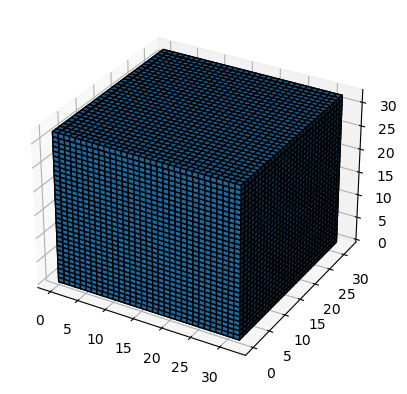

Fractured object (l1=0.0688):
Missing voxels: 1128 (24.49%)


NameError: name 'plot_vol' is not defined

In [15]:
l1loss = lambda a, b: np.mean(np.abs(a - b))
n = arq_voxels.shape[0]

# Uncomment the desire choice
i = np.random.choice(n) # get random index
# i = np.random.choice(np.argsort(improvement)[::-1][:int(n*.07)]) # get good result
# i = np.random.choice(np.argsort(improvement)[:int(n*.07)]) # get bad result

print('Complete object:')

#plot_vol(arq_voxels_target[i])###############################################################
n_voxels_target = np.sum(arq_voxels_target[i] == 1)

size = 10
print('Fractured object (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_voxels[i]))
n_voxels = np.sum(arq_voxels[i] == 1)
missing_points = n_voxels_target - n_voxels
perc_missing = missing_points * 100 / n_voxels_target
print(f'Missing voxels: {missing_points} (%.2f%%)' % perc_missing)
plot_vol(arq_voxels[i], s=size)

print('Reconstruction (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_result[i]))
missing_points_result = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 0)
extra_points = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 1)
print(f'Missing voxels    : {missing_points} -> {missing_points_result}')
print(f'Extra voxels added: {extra_points}')
plot_reconstruction(arq_voxels[i], arq_result[i], s=size)
# plot_reconstruction(arq_voxels[i], arq_voxels_target[i], s=size)
rerecon = model.predict_one(arq_result[i], 'arq', decode_label=True)
plot_reconstruction(arq_voxels[i], rerecon[0], s=size)
rererecon = model.predict_one(arq_result[i], 'arq', decode_label=True)
plot_reconstruction(arq_voxels[i], rererecon[0], s=size)

In [ ]:
# n = voxels.shape[0]

# # Uncomment the desire choice
# i = np.random.choice(n) # get random index
# # i = np.random.choice(np.argsort(improvement)[::-1][:int(n*.07)]) # get good result
# # i = np.random.choice(np.argsort(improvement)[:int(n*.07)]) # get bad result

# print(f'Complete object ({model.label_encoder.inverse_transform(labels[i])}):')
# plot_vol(voxels_target[i])

# size = 10
# print('Fractured object (l1=%.4f):' % l1loss(voxels_target[i], voxels[i]))
# missing_points = np.sum((voxels_target[i] - voxels[i]))
# print(f'Missing voxels: {missing_points}')
# plot_vol(voxels[i], s=size)

# print('Reconstruction (l1=%.4f):' % l1loss(voxels_target[i], result[i]))
# missing_points_result = np.sum((voxels_target[i] + (result[i] > 0)) == 0)
# extra_points = np.sum((voxels_target[i] + (result[i] > 0)) == 1)
# print(f'Missing voxels    : {missing_points} -> {missing_points_result}')
# print(f'Extra voxels added: {extra_points}')
# plot_reconstruction(voxels[i], result[i], s=size)